Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script runs daily, reads in CSV files with a sorted order of homes (most attractive at the top to least attractive at the bottom), and a 'ypred' variable that reflects the scripts absolute metric (like P&L or probability of sale).

The script compares each list with homes that were sold, and identifies closed transactions ('positives') as well as the top 10 properties that each model identified that didn't sell ('negatives'). The remainder is considered 'control set'. 

For the overall data set, and specifically for each of those 3 groups, we output the average 'ypred' value, what number and percentage of homes sold from each.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

# how old a target list to compare to the current target list
lag_days = 40

pd.set_option('display.max_colwidth', -1)
discount = 0.050

# to remove all the random far away areas - PHX only
zipcode_list = ['85006', '85007', '85008', '85009', '85013', '85015', '85016', '85017',
       '85018', '85019', '85020', '85021', '85022', '85023', '85024',
       '85027', '85028', '85029', '85031', '85033', '85035', '85037',
       '85040', '85041', '85043', '85044', '85048', '85050', '85051',
       '85053', '85085', '85086', '85087', '85118', '85138', '85139',
       '85142', '85143', '85202', '85203', '85204', '85205', '85206',
       '85207', '85209', '85210', '85212', '85213', '85215', '85224',
       '85225', '85226', '85233', '85234', '85248', '85249', '85250',
       '85251', '85253', '85254', '85255', '85257', '85258', '85262',
       '85266', '85286', '85295', '85296', '85297', '85298', '85301',
       '85302', '85303', '85304', '85305', '85306', '85308', '85310',
       '85323', '85326', '85331', '85335', '85339', '85340', '85351',
       '85353', '85355', '85373', '85374', '85375', '85382', '85383',
       '85388', '85390', '85392', '85396', '85704', '85705', '85706',
       '85711', '85712']

In [2]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [3]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [4]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12,13,14,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
closed.head()

,,price,transaction_status,date_listed,date_closed,days_on_market,transaction_type,price_listed,price_closed,date_transacted_latest,fsbo,...,school_district_id_60.0,school_district_id_67.0,school_district_id_68.0,school_district_id_75.0,school_district_id_76.0,school_district_id_87.0,school_district_id_90.0,school_district_id_93.0,school_district_id_96.0,school_district_id_nan
property_id,transaction_id,,,,,,,,,,,,,,,,,,,,,
326985,23755876,155000,closed,2014-06-23,5550,263.0,sales,179900.0,155000,2015-03-13,0.0,...,0,0,1,0,0,0,0,0,0,0
9021173,23755419,65000,closed,2008-10-17,3239,27.0,sales,72000.0,65000,2008-11-13,0.0,...,0,0,0,0,0,0,0,1,0,0
9021161,23755319,282811,closed,NaN,2182,NaN,sales,NaN,282811,2005-12-22,0.0,...,0,0,0,0,1,0,0,0,0,0
9021147,23755219,125000,closed,NaN,4668,NaN,sales,130000.0,125000,2012-10-12,0.0,...,0,0,0,0,0,0,0,0,0,0
7414199,23753957,189500,closed,2017-08-03,6466,42.0,sales,189500.0,189500,2017-09-14,0.0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
# read in prior target list for backtesting purposes
model_results = np.empty([0,7])
for lag_days in range(1,2):
    print("Lag days %i\n\n" % lag_days)
    try:
        prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
        backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
        y_all = prior_target_list.good_sell_prob.mean()
        y_sold = backtest.good_sell_prob.mean()

        pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
        slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
              % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

        num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
        positives = backtest[backtest.good_sell_prob > pos_trigger]
        y_pos = (-(positives.price - positives.list) / positives.list).median()
        num_sold = len(positives.index)
        if num_sold == 0:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
        else:
            slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
                  % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

        neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
        num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
        negatives = backtest[backtest.good_sell_prob < neg_trigger]
        y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
        num_sold = len(negatives.index)

        if num_sold == 0:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
        else:
            slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
                  % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

        slack(backtest.to_string())
        backtest.to_csv("median_check.csv")
        # store results in arrays for graphing
        r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
        model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Lag days 1


Slacking: Prior target list length: 4333	Num sold: 0	Avg good sell prob: 0.548742	Avg good sell prob of sold: nan
Slacking: Num of homes with good_sell_prob > 0.620832: 1083	Perc of those sold: NONE	Med disc to list: NA
Slacking: Num of homes with good_sell_prob < 0.502148: 1083	Perc of those sold: NONE	Median disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, good_sell_prob, list, url, lat, long, date_listed, transaction_date, price, good_sell]
Index: []


In [7]:
import matplotlib.pyplot as plt
index = pd.Index(model_results[:,0], names='lag_days')
graph_results = pd.DataFrame(model_results[:,1:],index=index,columns=['num_for_sale', 'num_sold', 'perc_sold_good','discount_good', 'perc_sold_bad', 'discount_bad']) \
                    .sort_index(ascending=False)

graph_results.head()

,num_for_sale,num_sold,perc_sold_good,discount_good,perc_sold_bad,discount_bad
1.0,4333.0,0.0,0.0,NaN,0.0,NaN


In [8]:
# graph_results[['num_for_sale', 'discount_good','discount_bad']].plot(figsize=(14,14),secondary_y='num_for_sale')

In [9]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = -10000
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = -30000
    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: Prior target list length: 4333	Num sold: 0	Avg P&L: 0.548742	Avg predict price: nan	Avg sale price: nan
Slacking: Num of homes with pnl > -10000.000000: 234	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Num of homes with pnl < -30000.000000: 3349	Perc of those sold: NONE	Avg disc to list: NA
Slacking: Empty DataFrame
Columns: [address, zipcode, pnl, predicted_price, list, url, price, good_sell]
Index: []


In [10]:
vb = pd.read_csv('value_buy/vb_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'pnl'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'good_sell_prob'}) \
       .drop_duplicates()
        
vb = vb[~vb.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of value buy\t%i" % len(vb.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([vb,gs],axis=1, join='inner')

c['pnl_percent'] = (c.pnl / c.list)

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of value buy	4386
Len of good sell	4400


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


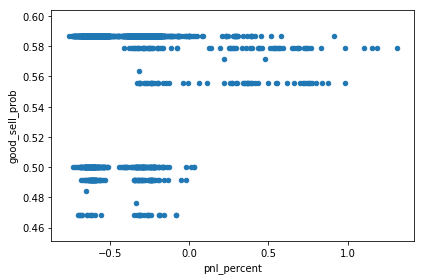

In [11]:
url = plot_rounds(c.query('good_sell_prob > 0.00').plot.scatter(x='pnl_percent', y='good_sell_prob'))
slack("", url, "Model Correlation")

In [12]:
# ran both data datasets and combine to create an equally weighted ensemble ranking
c["pnl_rank"] = c.pnl.rank(ascending=False)
c["gs_rank"] = c.good_sell_prob.rank(ascending=False)
c["rank"] = (c.pnl_rank + c.gs_rank)
c["zipcode"] = c.zipcode.apply(str)

# filter the output to remove duds
d = c[(c.pnl_percent > -0.2) & (c.good_sell_prob > 0.4) & (c.zipcode.isin(zipcode_list))]

In [13]:
d = c.sort_values("rank").nsmallest(20, "gs_rank")

file = csv_path + 'ensemble/comb_target_list_' + today.strftime('%Y%m%d') + '.csv'
np.round(d[['address', 'zipcode','list','predicted_price','pnl_percent','good_sell_prob','rank','url']], 4).to_csv(file)

slacker.files.upload(file, channels='#progress')

In [14]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

In [15]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [16]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

345909
5313 W Raymond St, Phoenix, AZ 85043 
135
                                                          address      dist
property_id transaction_id                                                 
345909      22262250        5313 W Raymond St, Phoenix, AZ 85043   0.000000
346030      23649636        5325 W Raymond St, Phoenix, AZ 85043   0.058049
346201      22641216        5404 W Albeniz Pl, Phoenix, AZ 85043   0.164522
40816       22403951        5132 W Fulton St, Phoenix, AZ 85043    0.172910
345649      23753551        5217 W Odeum Ln, Phoenix, AZ 85043     0.181993
1092452
725 W Sterling Pl, Chandler, AZ 85225 
149
                                                            address      dist
property_id transaction_id                                                   
1092452     22040999        725 W Sterling Pl, Chandler, AZ 85225    0.000000
1097000     17857519        894 W Boxelder Pl, Chandler, AZ 85225    0.125069
1085054     17270400        3427 N Hartford St, Chandler

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                            address      dist
property_id transaction_id                                                   
8950800     22069533        2501 N Nebraska St, Chandler, AZ 85225   0.000000
9020650     23755084        324 W Rosal Pl, Chandler, AZ 85225       0.181655
1088725     22710184        519 W Palomino Dr, Chandler, AZ 85225    0.304194
1079037     23754279        2192 N Holguin Way, Chandler, AZ 85225   0.365228
1078999     22740499        2184 N Holguin Way, Chandler, AZ 85225   0.370606
227710
13024 S 47th St, Phoenix, AZ 85044 
126
                                                         address      dist
property_id transaction_id                                                
227710      22028046        13024 S 47th St, Phoenix, AZ 85044    0.000000
8973913     22735745        13422 S 47th Pl, Phoenix, AZ 85044    0.118561
9020011     22741263        9220 S 47th Pl, Phoenix, AZ 85044     0.150534
228743      22692979        1340

In [17]:
d

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
345909,22262250,137278.37500,287278.37500,"5313 W Raymond St, Phoenix, AZ 85043",85043,0.586812,150000,https://www.zillow.com/homedetails/5313-W-Raymond-St-Phoenix-AZ-85043/67788825_zpid/,33.4148,-112.174,2017-07-05,2017-07-05,0.915189,8.0,857.0,865.0
1092452,22040999,104158.78125,284158.78125,"725 W Sterling Pl, Chandler, AZ 85225",85225,0.586812,180000,https://www.zillow.com/homedetails/725-W-Sterling-Pl-Chandler-AZ-85225/8200117_zpid/,33.3551,-111.856,2017-06-21,2017-06-21,0.578660,38.0,857.0,895.0
8950800,22069533,97995.84375,286995.84375,"2501 N Nebraska St, Chandler, AZ 85225",85225,0.586812,189000,https://www.zillow.com/homedetails/2501-N-Nebraska-St-Chandler-AZ-85225/8177416_zpid/,33.3425,-111.845,2017-06-15,2017-06-15,0.518497,45.0,857.0,902.0
227710,22028046,88900.31250,283900.31250,"13024 S 47th St, Phoenix, AZ 85044",85044,0.586812,195000,https://www.zillow.com/homedetails/13024-S-47th-St-Phoenix-AZ-85044/8150858_zpid/,33.3260,-111.983,2017-06-08,2017-06-08,0.455899,54.0,857.0,911.0
7438010,22032231,86379.28125,294379.28125,"4116 E Joan De Arc Ave, Phoenix, AZ 85032",85032,0.586812,208000,https://www.zillow.com/homedetails/4116-E-Joan-De-Arc-Ave-Phoenix-AZ-85032/7823229_zpid/,33.6096,-111.993,2017-05-04,2017-05-04,0.415285,56.0,857.0,913.0
301456,22289975,85701.62500,305401.62500,"6705 N Ocotillo Hermosa Cir, Phoenix, AZ 85016",85016,0.586812,219700,https://www.zillow.com/homedetails/6705-N-Ocotillo-Hermosa-Cir-Phoenix-AZ-85016/7807681_zpid/,33.5349,-112.044,2017-07-09,2017-07-09,0.390085,58.0,857.0,915.0
8950656,22079788,83299.12500,295799.12500,"3838 E Willow Ave, Phoenix, AZ 85032",85032,0.586812,212500,https://www.zillow.com/homedetails/3838-E-Willow-Ave-Phoenix-AZ-85032/7813940_zpid/,33.6083,-111.998,2017-06-20,2017-06-20,0.391996,64.0,857.0,921.0
560700,22105906,81784.93750,286684.93750,"1026 W Dragoon Ave, Mesa, AZ 85210",85210,0.586812,204900,https://www.zillow.com/homedetails/1026-W-Dragoon-Ave-Mesa-AZ-85210/7597888_zpid/,33.4028,-111.854,2017-06-19,2017-06-19,0.399146,67.0,857.0,924.0
7567072,22093889,81692.68750,291692.68750,"4417 E Maldonado Dr, Phoenix, AZ 85042",85042,0.586812,210000,https://www.zillow.com/homedetails/4417-E-Maldonado-Dr-Phoenix-AZ-85042/7551938_zpid/,33.3848,-111.986,2017-06-26,2017-06-26,0.389013,68.0,857.0,925.0


In [18]:
d.head()

,,pnl,predicted_price,address,zipcode,good_sell_prob,list,url,lat,long,date_listed,transaction_date,pnl_percent,pnl_rank,gs_rank,rank
property_id,transaction_id,,,,,,,,,,,,,,,
345909,22262250,137278.37500,287278.37500,"5313 W Raymond St, Phoenix, AZ 85043",85043,0.586812,150000,https://www.zillow.com/homedetails/5313-W-Raymond-St-Phoenix-AZ-85043/67788825_zpid/,33.4148,-112.174,2017-07-05,2017-07-05,0.915189,8.0,857.0,865.0
1092452,22040999,104158.78125,284158.78125,"725 W Sterling Pl, Chandler, AZ 85225",85225,0.586812,180000,https://www.zillow.com/homedetails/725-W-Sterling-Pl-Chandler-AZ-85225/8200117_zpid/,33.3551,-111.856,2017-06-21,2017-06-21,0.578660,38.0,857.0,895.0
8950800,22069533,97995.84375,286995.84375,"2501 N Nebraska St, Chandler, AZ 85225",85225,0.586812,189000,https://www.zillow.com/homedetails/2501-N-Nebraska-St-Chandler-AZ-85225/8177416_zpid/,33.3425,-111.845,2017-06-15,2017-06-15,0.518497,45.0,857.0,902.0
227710,22028046,88900.31250,283900.31250,"13024 S 47th St, Phoenix, AZ 85044",85044,0.586812,195000,https://www.zillow.com/homedetails/13024-S-47th-St-Phoenix-AZ-85044/8150858_zpid/,33.3260,-111.983,2017-06-08,2017-06-08,0.455899,54.0,857.0,911.0
7438010,22032231,86379.28125,294379.28125,"4116 E Joan De Arc Ave, Phoenix, AZ 85032",85032,0.586812,208000,https://www.zillow.com/homedetails/4116-E-Joan-De-Arc-Ave-Phoenix-AZ-85032/7823229_zpid/,33.6096,-111.993,2017-05-04,2017-05-04,0.415285,56.0,857.0,913.0
